# HOMEWORK PART 2a

---

Download the accompanying ZIP file which includes MATLAB code for solving (i) A reaction-diffusion system of equations, and (ii) The Kuramoto-Sivashinsky (KS) equation.
1. Train a NN that can advance the solution from t to t + ∆t for the KS equation
2. Compare your evolution trajectories for your NN against using the ODE time-stepper provided with
different initial conditions
3. For the reaction-diffusion system, first project to a low-dimensional subspace via the SVD and see how forecasting works in the low-rank variables.

The Kuramoto-Sivashinsky equation represents a pattern forming system with spatio-temporal chaotic behavior. In one dimension we can write the equation as:

\begin{align}
u_t &= -uu_x - u_{xx} - u_{xxxx} \quad \& \quad \textit{periodic BCs}
\end{align}

In [115]:
%matplotlib notebook
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split

import torch
import torch.utils.data as Data
torch.manual_seed(113)    # reproducible results
np.random.seed(113)
seed = 113

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42

In [0]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device)

In [116]:
#http://www.databookuw.com/page-17/
#https://people.maths.ox.ac.uk/trefethen/pdectb/kuramoto2.pdf

# Modification  nplt = np.floor((tmax / 250) / h) with nplt = 32, in this way
# The number of samples in time does not depend on the final time

def KS(length, x_dim, final_t):
    """Kuramoto-Sivashinsky equation solver parametrized on the interval length"""
    N = x_dim
    x = length * np.pi * np.arange(1, N + 1) / N
    u = np.cos(x / 16) * (1 + np.sin(x / 16)) # initial function
    v = np.fft.fft(u)

    #Spatial grid and initial condition:
    h = 0.025
    k = np.concatenate([np.arange(0, N / 2), [0], np.arange(-N / 2 + 1, 0)]) / 16
    L = k ** 2 - k ** 4
    E, E2 = np.exp(h * L), np.exp(h * L / 2)
    M = 16
    r = np.exp(1j * np.pi * (np.arange(1, M + 1) - .5) / M)
    LR = h * np.tile(L, (M, 1)).T + np.tile(r, (N, 1))
    Q = h * np.real(np.mean((np.exp(LR / 2) - 1) / LR, axis=1))
    f1 = h * np.real(np.mean((-4 - LR + np.exp(LR) * (4 - 3 * LR + LR ** 2)) / LR ** 3, axis=1))
    f2 = h * np.real(np.mean((2 + LR + np.exp(LR) * (-2 + LR)) / LR ** 3, axis=1))
    f3 = h * np.real(np.mean((-4 - 3 * LR - LR ** 2 + np.exp(LR) * (4 - LR)) / LR ** 3, axis=1))

    # Main time-stepping loop:
    uu = u
    tt = 0
    tmax = final_t
    nmax = round(tmax / h) 
    #nplt = np.floor((tmax / 250) / h) 
    nplt = 32
    g = -0.5j * k;
    for n in range(1, nmax + 1):
        t = n * h
        Nv = g * np.fft.fft(np.real(np.fft.ifft(v)) ** 2)
        a = E2 * v + Q * Nv
        Na = g * np.fft.fft(np.real(np.fft.ifft(a)) ** 2)
        b = E2 * v + Q * Na
        Nb = g * np.fft.fft(np.real(np.fft.ifft(b)) ** 2)
        c = E2 * a + Q * (2 * Nb - Nv);
        Nc = g * np.fft.fft(np.real(np.fft.ifft(c)) ** 2)
        v = E * v + Nv * f1 + 2 * (Na + Nb) * f2 + Nc * f3 
        if np.mod(n, nplt) == 0:
            u = np.real(np.fft.ifft(v))
            uu = np.vstack([uu, u]) 
            tt = np.append(tt, t)
    return x, uu, tt

Personalized cmap

In [117]:
colors = [(0, 0, 0), (0.5, 0.5, 0.5), (1, 1, 1), (1, 0.4, 0.4), (1, 0., 0.)]
cmap_name = 'dark_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

## Point 1: Train a NN that can advance the solution from t to t + ∆t for the KS equation.

In [118]:
L = 32
n_x = 128
x, u, t = KS(L, n_x, 100)
n_t = len(t)
t_max = t[-1]

X = u[:-1, :]
y = u[1:, :]

<IPython.core.display.Javascript object>


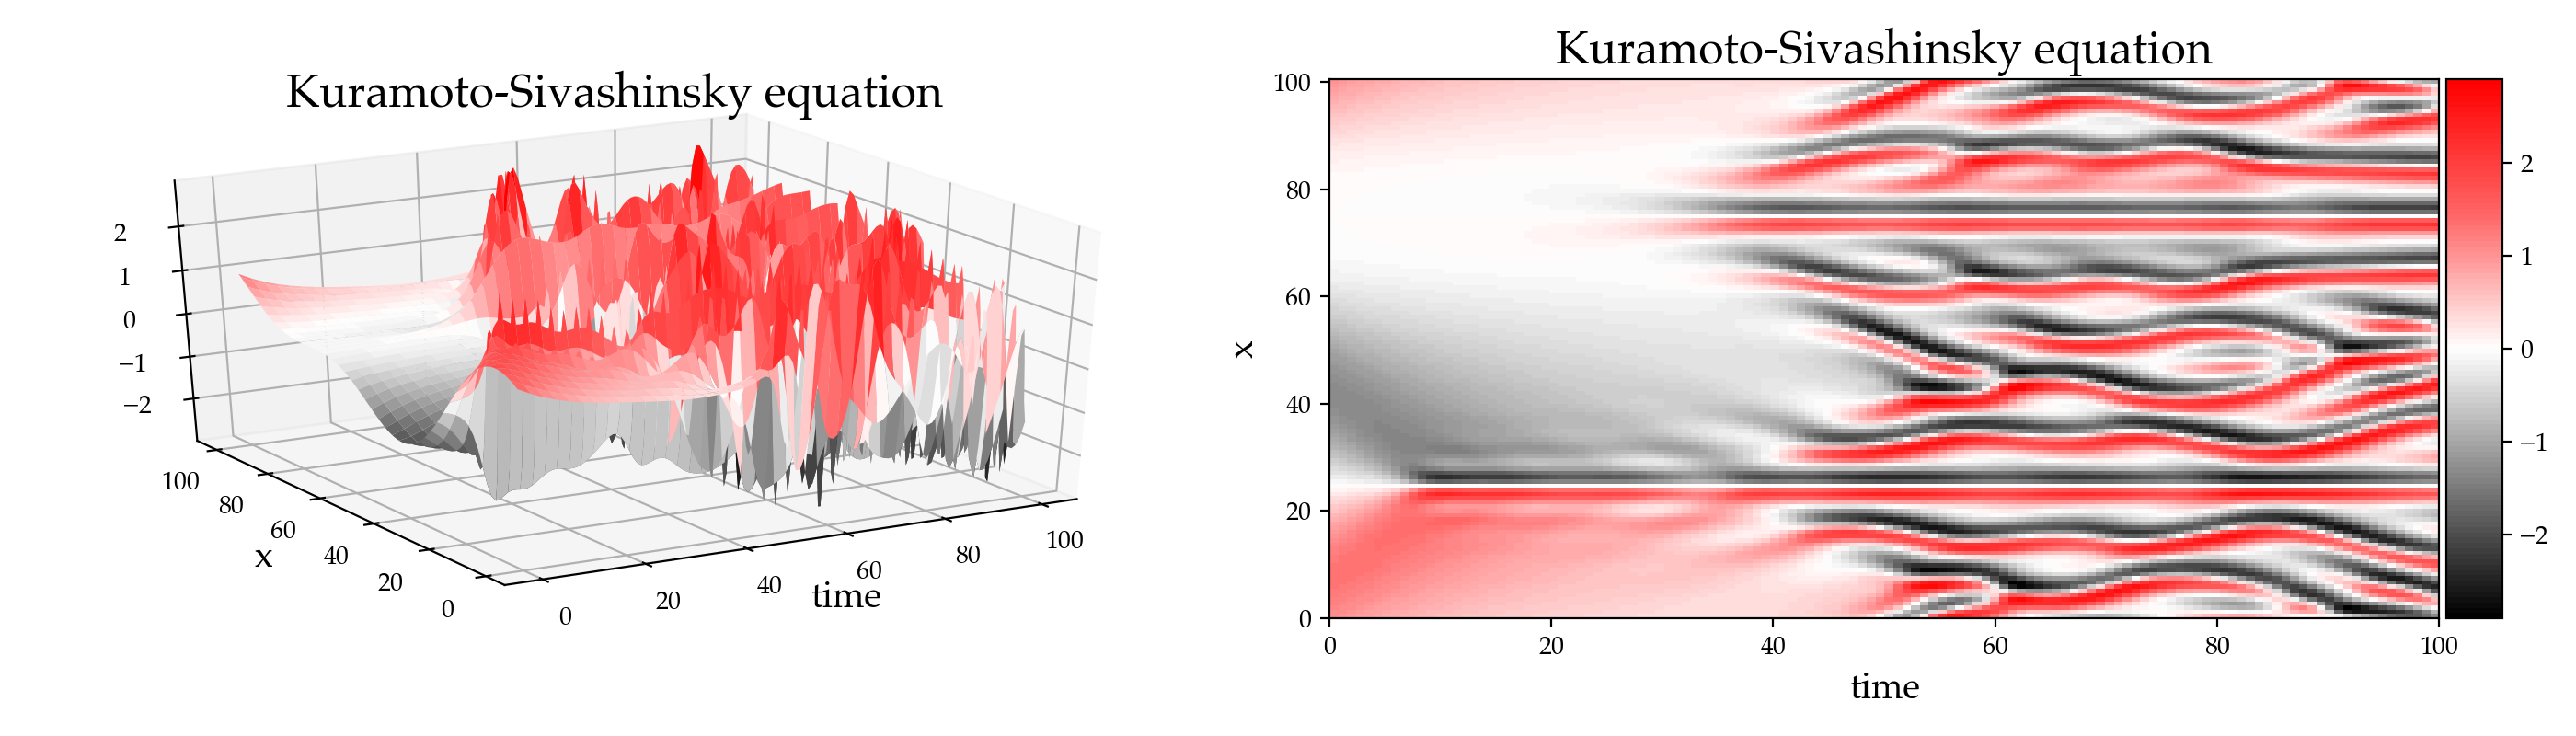

In [119]:
fig = plt.figure(figsize=(14, 4))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
ax = plt.subplot(gs[0, 0], projection='3d')
T, XX = np.meshgrid(t, x)
h = ax.plot_surface(T, XX, u.T, cmap=cm)
ax.view_init(elev=30., azim=-120)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Kuramoto-Sivashinsky equation', fontsize = 18)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u.T, interpolation='nearest', cmap=cm,
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Kuramoto-Sivashinsky equation', fontsize = 18)

gs.tight_layout(fig)

Train / test split

In [0]:
X_train, _X_tmp, y_train, _y_tmp = train_test_split(X, y, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(_X_tmp, _y_tmp, test_size=0.5, random_state=seed+1)

Network architecture

In [120]:
class MLPNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(MLPNN, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H//2)
        self.linear3 = torch.nn.Linear(H//2, H)
        self.linear4 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        h_relu = self.linear2(h_relu).clamp(min=0)
        h_relu = self.linear3(h_relu).clamp(min=0)
        y_pred = self.linear4(h_relu)
        return y_pred

In [0]:
batch = 16

train_dataset = Data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = Data.TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = Data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch, shuffle=False)
val_loader = Data.DataLoader(dataset=val_dataset, batch_size=X_val.shape[0], shuffle=False)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=X_test.shape[0], shuffle=False)

Let's train the network for different values of the number of neurons

In [0]:
D_in, H, D_out = n_x, int(n_x / 2), n_x

epochs = 5000

model1 = MLPNN(D_in, H, D_out)

if(os.path.isfile('net_weights/weights_NN_2a1')):
    model1.load_state_dict(torch.load('net_weights/weights_NN_2a1'))
    print(model1.eval())
else:
    criterion = torch.nn.MSELoss(reduction='sum') 
    optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)
    train_loss = []
    for epoch in range(epochs):
        for step, (batch_x, batch_y) in enumerate(train_loader):
            y_pred = model1(batch_x)
            loss = criterion(y_pred, batch_y)
            train_loss.append(loss.item())
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0:
            model1.eval()
            for step, (val_x, val_y) in enumerate(val_loader):
                val_pred = model1(val_x)
                loss_val = criterion(val_pred, val_y)
            model1.train()
            print("Iteration: ", epoch, " Loss: ", loss.item(), " Validation loss: ", loss_val.item())
    torch.save(model1.state_dict(), 'weights_NN_2a1')

MLPNN(
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=128, bias=True)
)


In [0]:
D_in, H, D_out = n_x, int(n_x), n_x

epochs = 4000

model2 = MLPNN(D_in, H, D_out)

if(os.path.isfile('net_weights/weights_NN_2a2')):
    model2.load_state_dict(torch.load('net_weights/weights_NN_2a2'))
    print(model2.eval())
else:
    criterion = torch.nn.MSELoss(reduction='sum') 
    optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)
    train_loss = []
    for epoch in range(epochs):
        for step, (batch_x, batch_y) in enumerate(train_loader):
            y_pred = model2(batch_x)
            loss = criterion(y_pred, batch_y)
            train_loss.append(loss.item())
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0:
            model2.eval()
            for step, (val_x, val_y) in enumerate(val_loader):
                val_pred = model2(val_x)
                loss_val = criterion(val_pred, val_y)
            model2.train()
            print("Iteration: ", epoch, " Loss: ", loss.item(), " Validation loss: ", loss_val.item())
    torch.save(model2.state_dict(), 'weights_NN_2a2')

MLPNN(
  (linear1): Linear(in_features=128, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=128, bias=True)
)


In [0]:
D_in, H, D_out = n_x, int(2 * n_x), n_x

epochs = 4000

model3 = MLPNN(D_in, H, D_out)

if(os.path.isfile('net_weights/weights_NN_2a3')):
    model3.load_state_dict(torch.load('net_weights/weights_NN_2a3'))
    print(model3.eval())
else:
    criterion = torch.nn.MSELoss(reduction='sum') 
    optimizer = torch.optim.Adam(model3.parameters(), lr=5e-5)
    train_loss = []
    for epoch in range(epochs):
        for step, (batch_x, batch_y) in enumerate(train_loader):
            y_pred = model3(batch_x)
            loss = criterion(y_pred, batch_y)
            train_loss.append(loss.item())
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0:
            model3.eval()
            for step, (val_x, val_y) in enumerate(val_loader):
                val_pred = model3(val_x)
                loss_val = criterion(val_pred, val_y)
            model3.train()
            print("Iteration: ", epoch, " Loss: ", loss.item(), " Validation loss: ", loss_val.item())
    torch.save(model3.state_dict(), 'weights_NN_2a3')

MLPNN(
  (linear1): Linear(in_features=128, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=128, bias=True)
)


In [0]:
D_in, H, D_out = n_x, int(3 * n_x), n_x

epochs = 4000

model4 = MLPNN(D_in, H, D_out)

if(os.path.isfile('net_weights/weights_NN_2a4')):
    model4.load_state_dict(torch.load('net_weights/weights_NN_2a4'))
    print(model4.eval())
else:
    criterion = torch.nn.MSELoss(reduction='sum') 
    optimizer = torch.optim.Adam(model4.parameters(), lr=1e-4)
    train_loss = []
    for epoch in range(epochs):
        for step, (batch_x, batch_y) in enumerate(train_loader):
            y_pred = model4(batch_x)
            loss = criterion(y_pred, batch_y)
            train_loss.append(loss.item())
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0:
            model4.eval()
            for step, (val_x, val_y) in enumerate(val_loader):
                val_pred = model4(val_x)
                loss_val = criterion(val_pred, val_y)
            model4.train()
            print("Iteration: ", epoch, " Loss: ", loss.item(), " Validation loss: ", loss_val.item())
    torch.save(model4.state_dict(), 'weights_NN_2a4')

MLPNN(
  (linear1): Linear(in_features=128, out_features=384, bias=True)
  (linear2): Linear(in_features=384, out_features=192, bias=True)
  (linear3): Linear(in_features=192, out_features=384, bias=True)
  (linear4): Linear(in_features=384, out_features=128, bias=True)
)


In [0]:
check_test = False
criterion = torch.nn.MSELoss(reduction='sum') 

with torch.no_grad():
    for step, (batch_x, batch_y) in enumerate(val_loader):
        y_pred1 = model1(batch_x)
        y_pred2 = model2(batch_x)
        y_pred3 = model3(batch_x)
        y_pred4 = model4(batch_x)
        loss_val1 = criterion(y_pred1, batch_y)
        loss_val2 = criterion(y_pred2, batch_y)
        loss_val3 = criterion(y_pred3, batch_y)
        loss_val4 = criterion(y_pred4, batch_y)
print("Model 1, Validation Loss: ", loss_val1.item() / len(batch_x))
print("Model 2, Validation Loss: ", loss_val2.item() / len(batch_x))
print("Model 3, Validation Loss: ", loss_val3.item() / len(batch_x))
print("Model 4, Validation Loss: ", loss_val4.item() / len(batch_x))

if check_test:
    with torch.no_grad():
          for step, (batch_x, batch_y) in enumerate(test_loader):
                y_pred = model(batch_x)
                loss_test = criterion(y_pred, batch_y)
    print(loss_test / len(batch_x))

Model 1, Validation Loss:  0.39471932252248126
Model 2, Validation Loss:  0.2607654134432475
Model 3, Validation Loss:  0.2820834318796794
Model 4, Validation Loss:  0.22032115856806436


In [0]:
# Free time marching
u1f, u2f, u3f, u4f = np.empty((n_t, n_x)), np.empty((n_t, n_x)), np.empty((n_t, n_x)), np.empty((n_t, n_x))

u1f[0, :], u2f[0, :], u3f[0, :], u4f[0, :] = X[0, :], X[0, :], X[0, :], X[0, :]
for i in range(n_t-1):
    with torch.no_grad():
        u1f[i+1, :] = model1(torch.from_numpy(u1f[i, :]).squeeze(0).float())
        u2f[i+1, :] = model2(torch.from_numpy(u2f[i, :]).squeeze(0).float())
        u3f[i+1, :] = model3(torch.from_numpy(u3f[i, :]).squeeze(0).float())
        u4f[i+1, :] = model4(torch.from_numpy(u4f[i, :]).squeeze(0).float())

In [0]:
# Guided time marching
tensor_X = torch.from_numpy(X).float()
with torch.no_grad():
    prediction1 = model1(tensor_X)
    prediction2 = model2(tensor_X)
    prediction3 = model3(tensor_X)
    prediction4 = model4(tensor_X)

u1g = np.vstack((tensor_X[0, :], prediction1))
u2g = np.vstack((tensor_X[0, :], prediction2))
u3g = np.vstack((tensor_X[0, :], prediction3))
u4g = np.vstack((tensor_X[0, :], prediction4))

In [0]:
t_train = t[X_train.shape[0]]

<IPython.core.display.Javascript object>


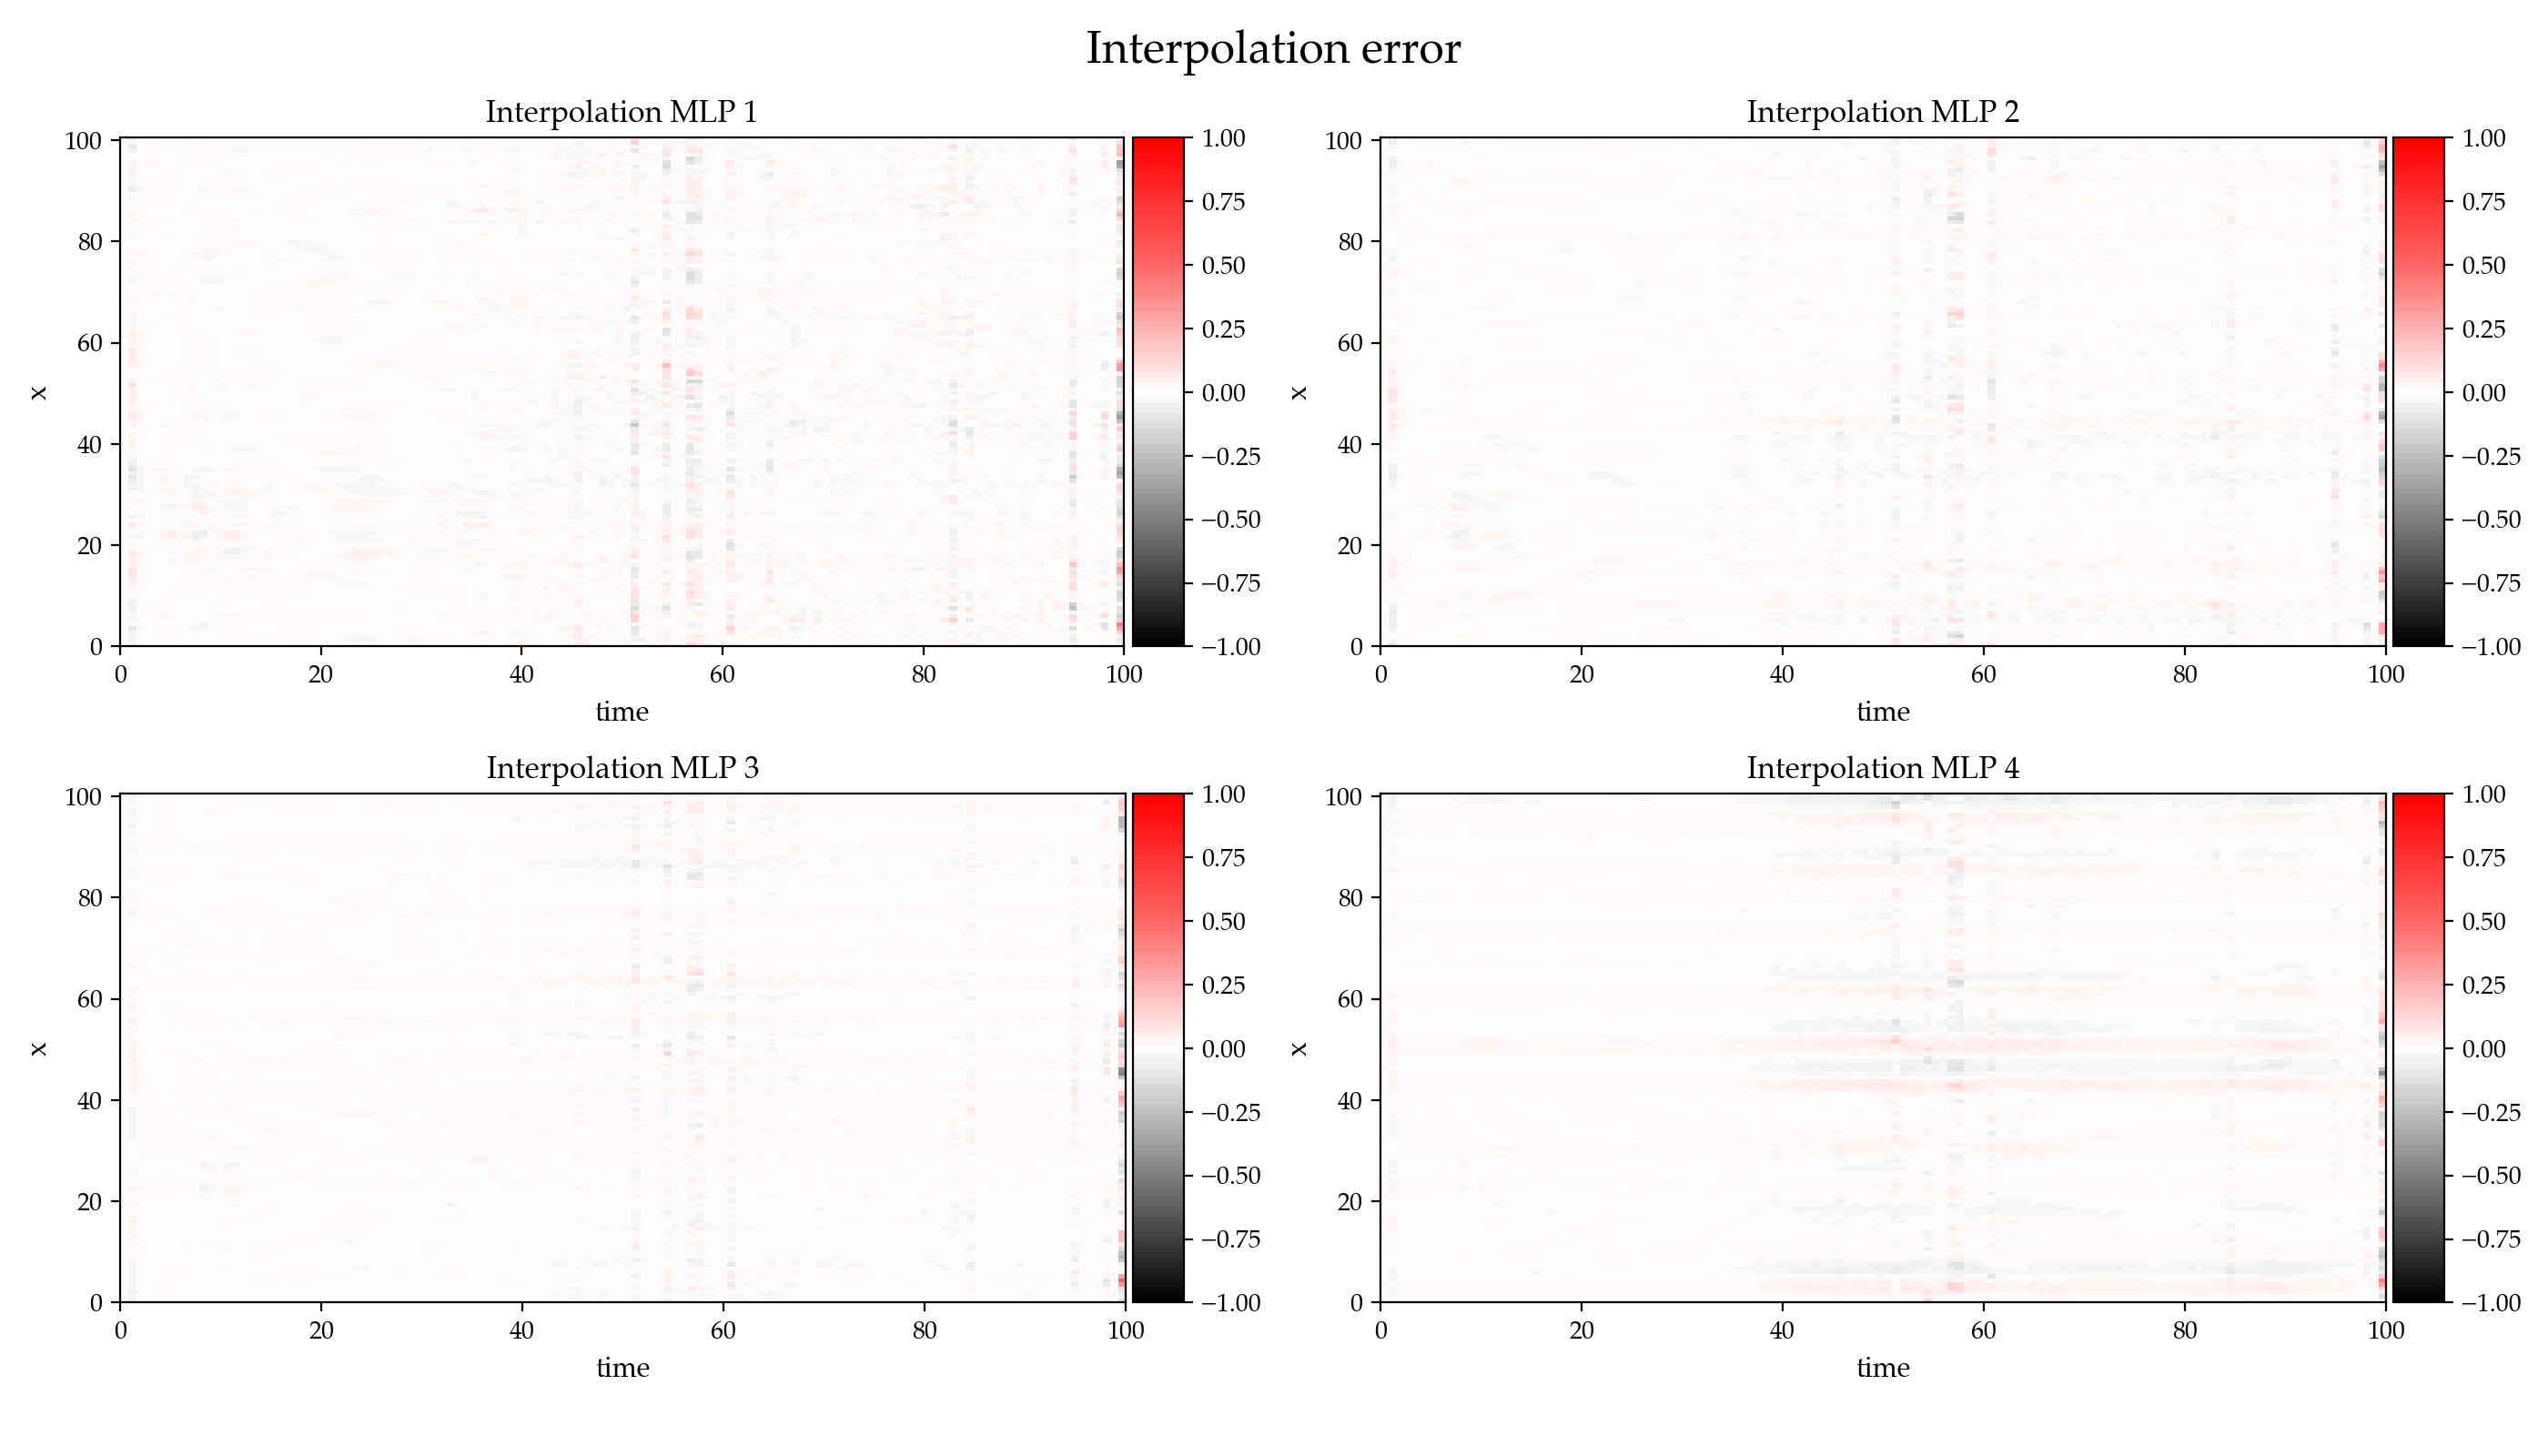

In [0]:
fig = plt.figure(figsize=(14, 8))
fig.suptitle("Interpolation error", fontsize=18)

norm = mpl.colors.Normalize(vmin=-1, vmax=1)

gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
ax = plt.subplot(gs[0, 0])
h = ax.imshow(u1g.T-u.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Interpolation MLP 1', fontsize = 12)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u2g.T-u.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Interpolation MLP 2', fontsize = 12)

ax = plt.subplot(gs[1, 0])
h = ax.imshow(u3g.T-u.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Interpolation MLP 3', fontsize = 12)

ax = plt.subplot(gs[1, 1])
h = ax.imshow(u4g.T-u.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Interpolation MLP 4', fontsize = 12)

gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/interp_err.png', format='png', dpi=1200)

<IPython.core.display.Javascript object>


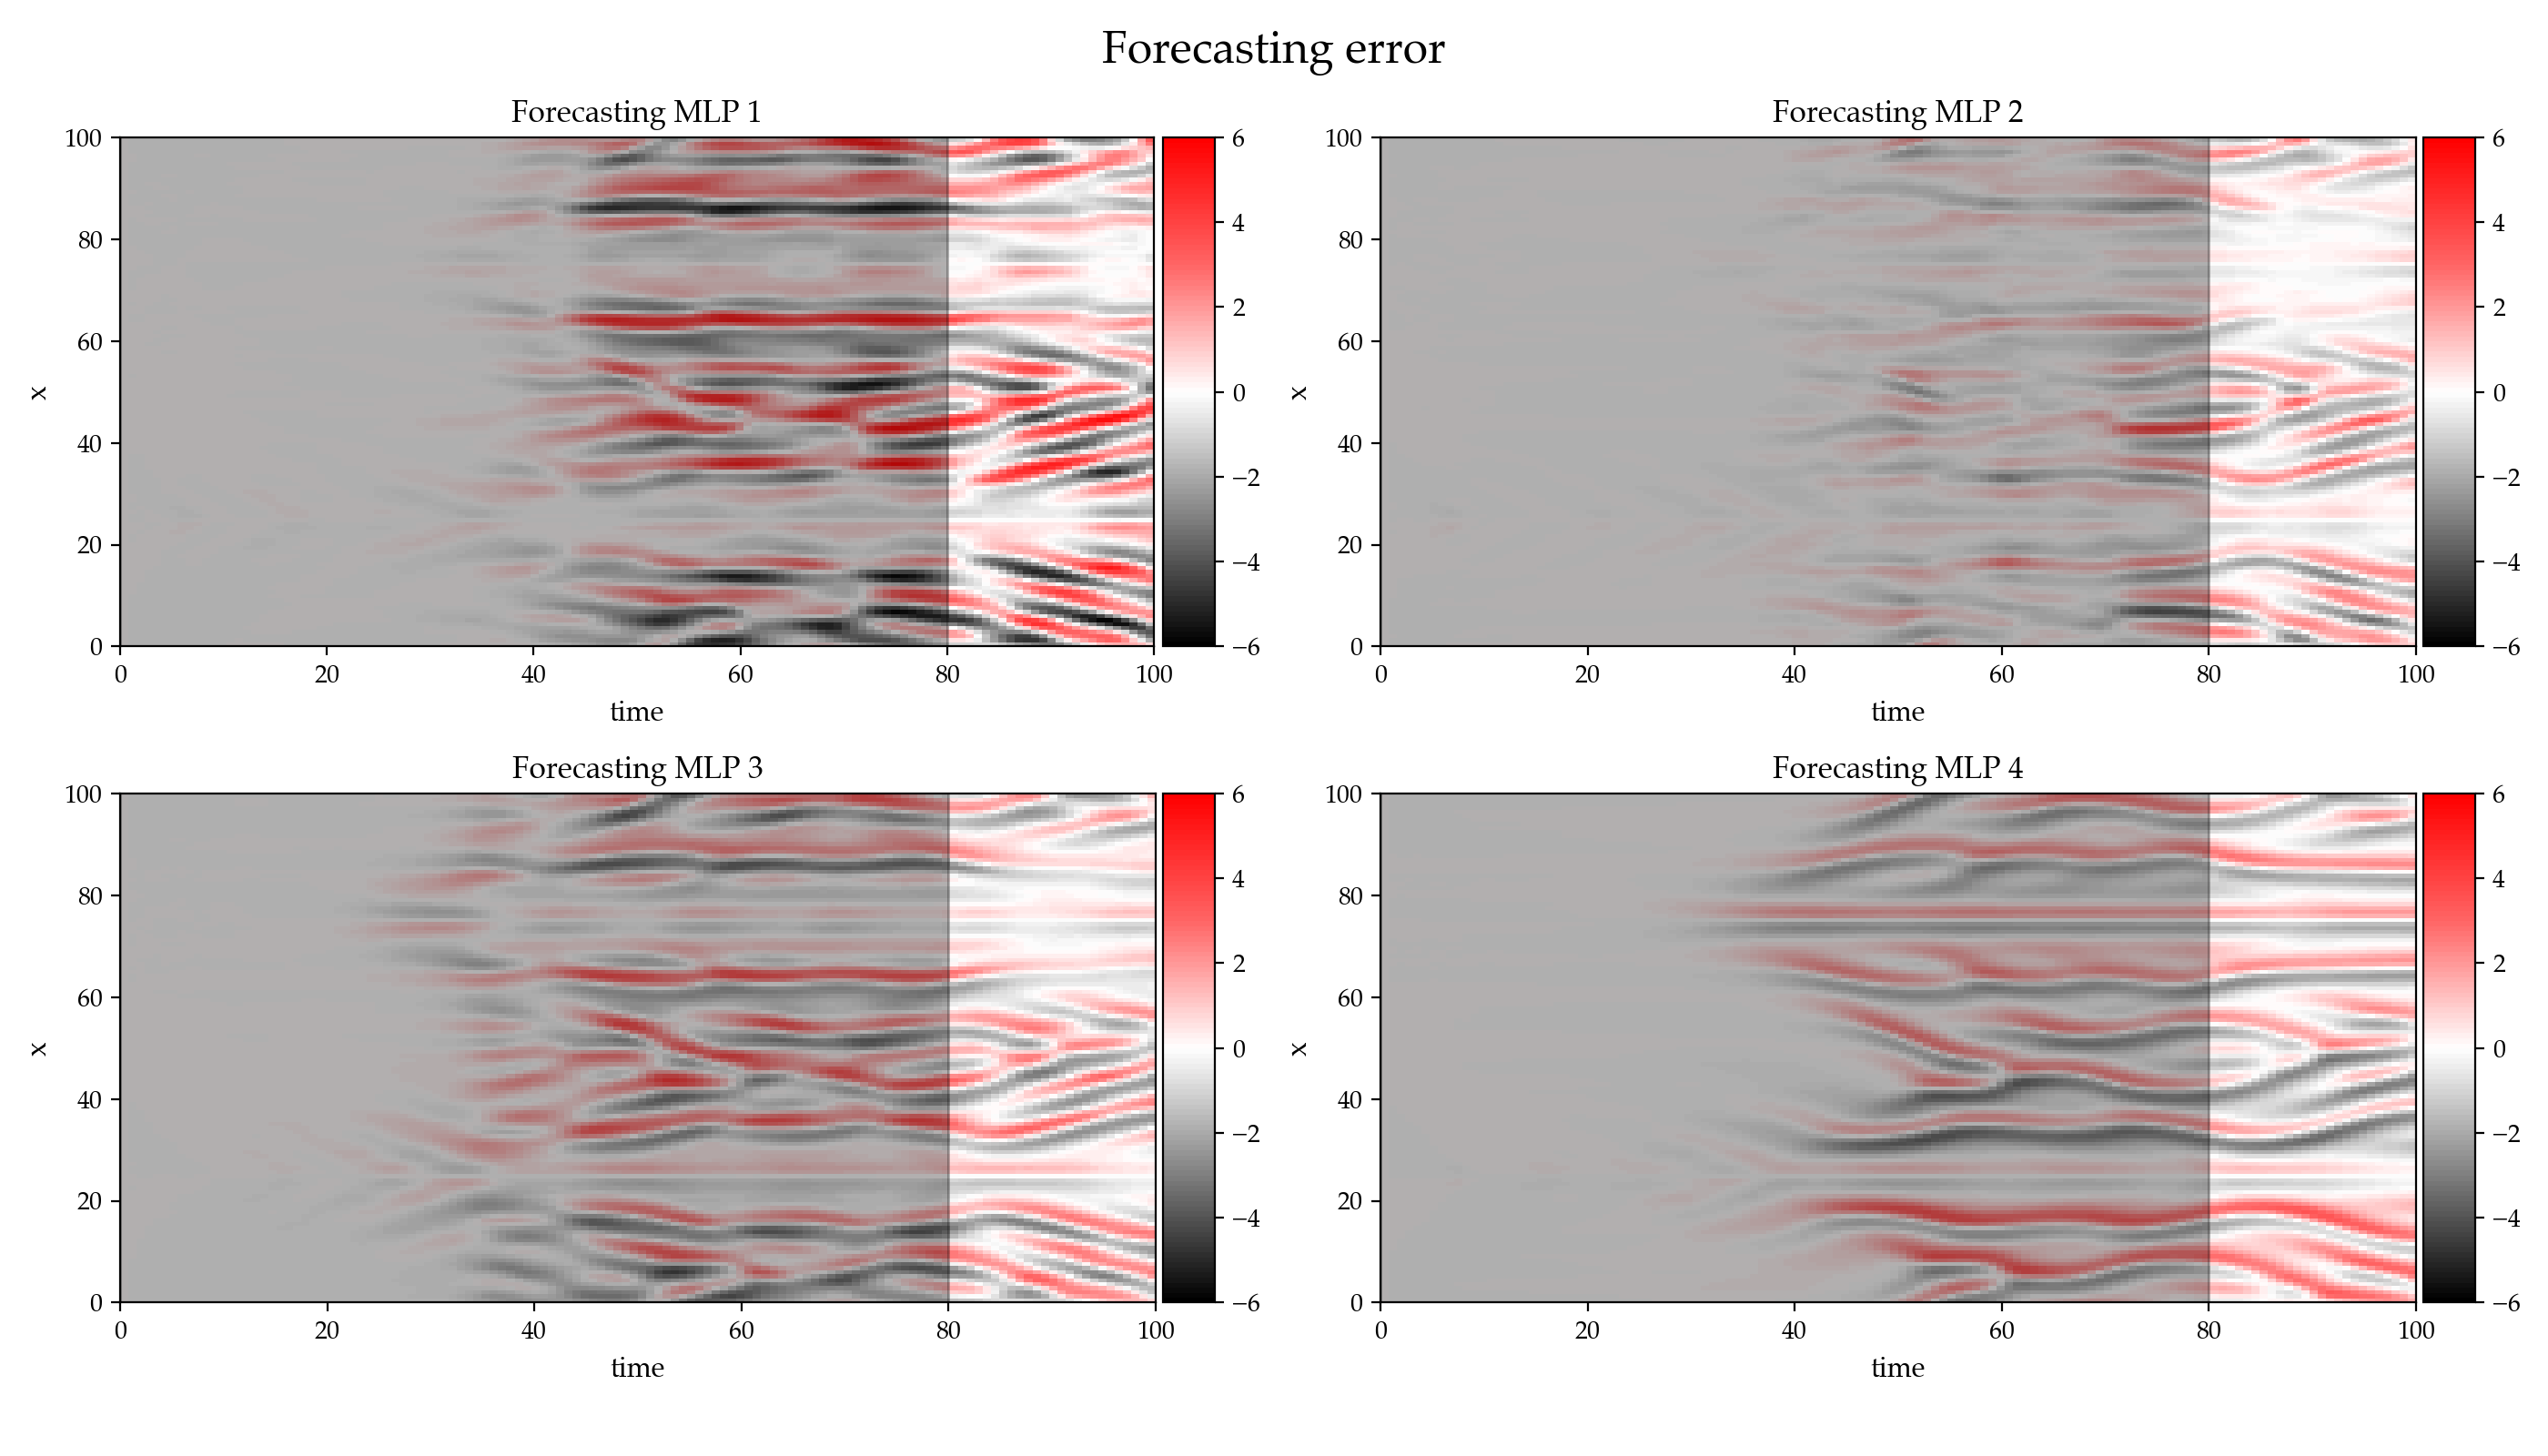

In [0]:
fig = plt.figure(figsize=(14, 8))
fig.suptitle("Forecasting error", fontsize=18)

norm = mpl.colors.Normalize(vmin=-6, vmax=6)

gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
ax = plt.subplot(gs[0, 0])
h = ax.imshow(u1f.T-u.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')

ax.fill([0, t_train, t_train, 0], [-100, -100, 200, 200], color='k', alpha=0.3)
ax.set_ylim([0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP 1', fontsize = 12)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u2f.T-u.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
ax.fill([0, t_train, t_train, 0], [-100, -100, 200, 200], color='k', alpha=0.3)
ax.set_ylim([0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP 2', fontsize = 12)

ax = plt.subplot(gs[1, 0])
h = ax.imshow(u3f.T-u.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
ax.fill([0, t_train, t_train, 0], [-100, -100, 200, 200], color='k', alpha=0.3)
ax.set_ylim([0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP 3', fontsize = 12)

ax = plt.subplot(gs[1, 1])
h = ax.imshow(u4f.T-u.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
ax.fill([0, t_train, t_train, 0], [-100, -100, 200, 200], color='k', alpha=0.3)
ax.set_ylim([0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP 4', fontsize = 12)

gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/fore_err.png', format='png', dpi=1200)

<IPython.core.display.Javascript object>


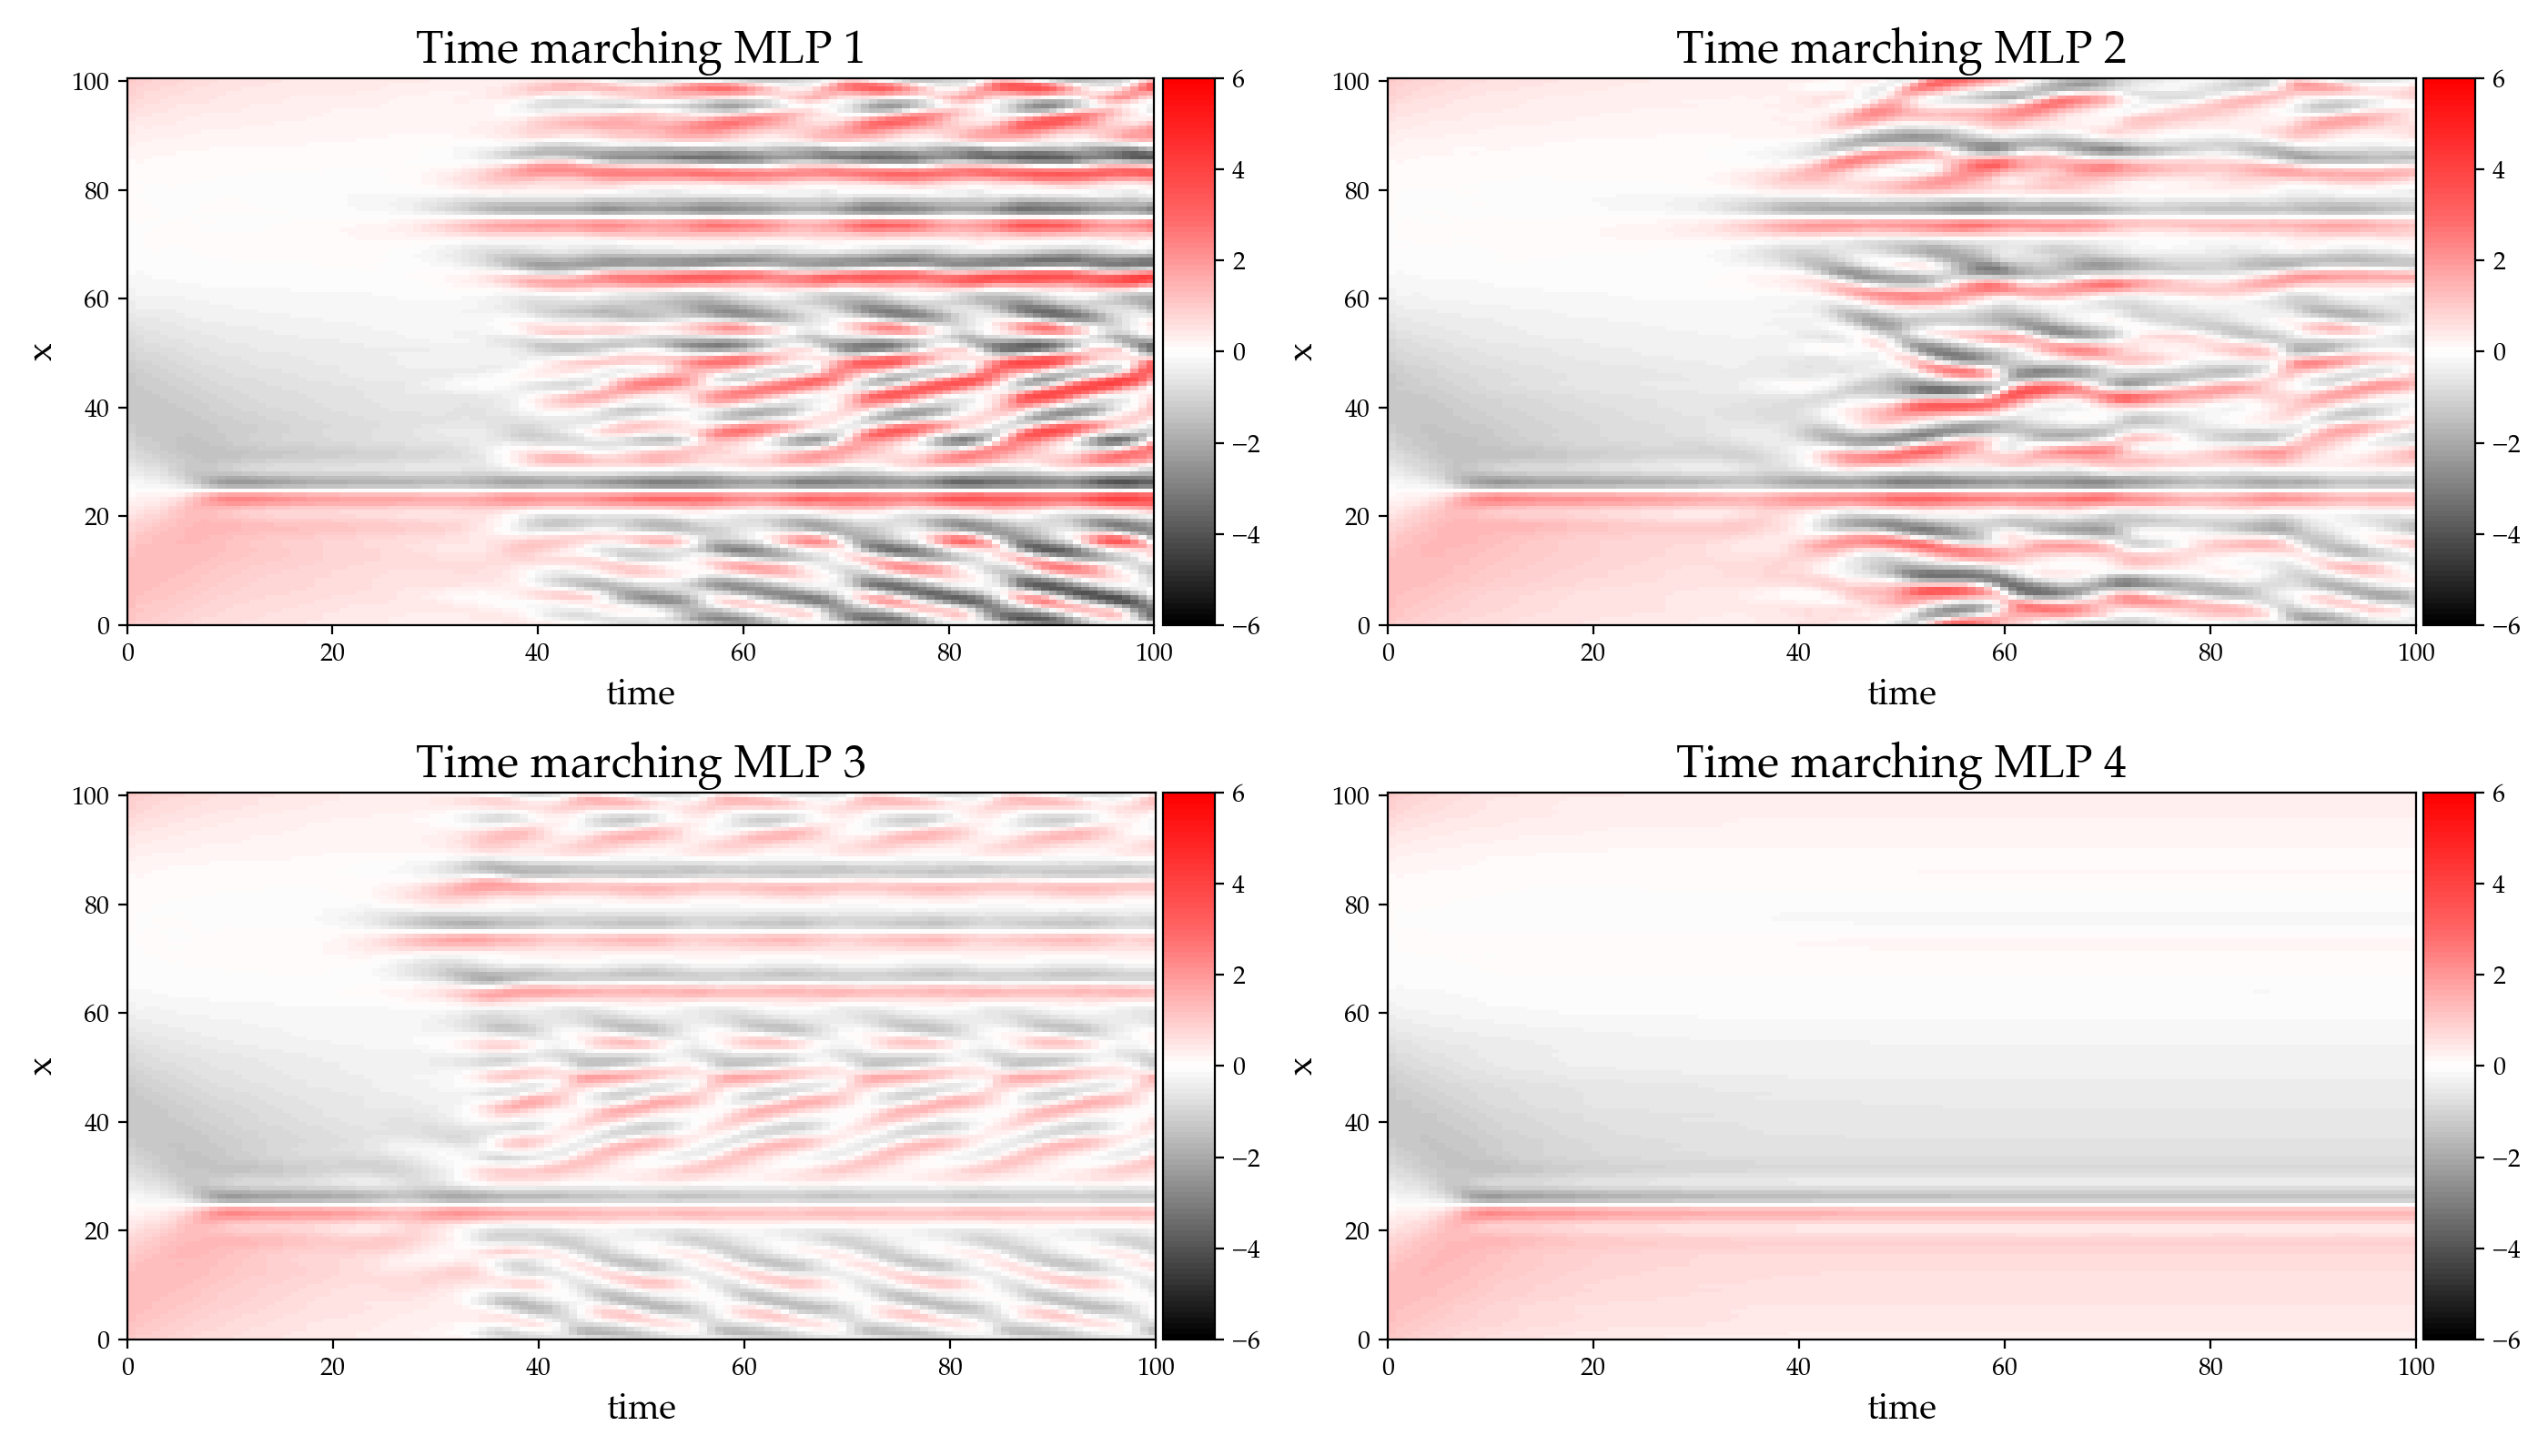

In [0]:
fig = plt.figure(figsize=(14, 8))

norm = mpl.colors.Normalize(vmin=-6, vmax=6)

gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
ax = plt.subplot(gs[0, 0])
h = ax.imshow(u1f.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Time marching MLP 1', fontsize = 18)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u2f.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Time marching MLP 2', fontsize = 18)

ax = plt.subplot(gs[1, 0])
h = ax.imshow(u3f.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Time marching MLP 3', fontsize = 18)

ax = plt.subplot(gs[1, 1])
h = ax.imshow(u4f.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('x', fontsize = 14)
ax.set_title('Time marching MLP 4', fontsize = 18)

gs.tight_layout(fig)

fig.savefig('figures/time_marching.png', format='png', dpi=1200)

In [0]:
from sklearn.metrics import r2_score
global_err1 = np.mean((u - u1f) ** 2)
global_err2 = np.mean((u - u2f) ** 2)
global_err3 = np.mean((u - u3f) ** 2)
global_err4 = np.mean((u - u4f) ** 2)

print('- - - - -')
print("Model 1, error: ", global_err1)
print('- - - - -')
print('\n')
print('- - - - -')
print("Model 2, error: ", global_err2)
print('- - - - -')
print('\n')
print('- - - - -')
print("Model 3, error: ", global_err3)
print('- - - - -')
print('\n')
print('- - - - -')
print("Model 4, error: ", global_err4)
print('- - - - -')

- - - - -
Model 1, error:  1.863443798688998
- - - - -


- - - - -
Model 2, error:  0.4134245240117199
- - - - -


- - - - -
Model 3, error:  1.076301421207606
- - - - -


- - - - -
Model 4, error:  0.9898661164744851
- - - - -


Forecasting

In [0]:
L = 32
t_max1 = 100
x_f1, u_f1, t_f1 = KS(L, n_x, t_max1)
n_t1 = len(t_f1)

# Free time marching
u_frc1 = np.empty((n_t1, n_x))
u_frc1[0, :] = u_f1[0, :]
for i in range(n_t1-1):
    with torch.no_grad():
        u_frc1[i+1, :] = model2(torch.from_numpy(u_frc1[i, :]).squeeze(0).float())
        
t_max2 = 200
x_f2, u_f2, t_f2 = KS(L, n_x, t_max2)
n_t2 = len(t_f2)

# Free time marching
u_frc2 = np.empty((n_t2, n_x))
u_frc2[0, :] = u_f2[0, :]
for i in range(n_t-1):
    with torch.no_grad():
        u_frc2[i+1, :] = model2(torch.from_numpy(u_frc2[i, :]).squeeze(0).float())

<IPython.core.display.Javascript object>


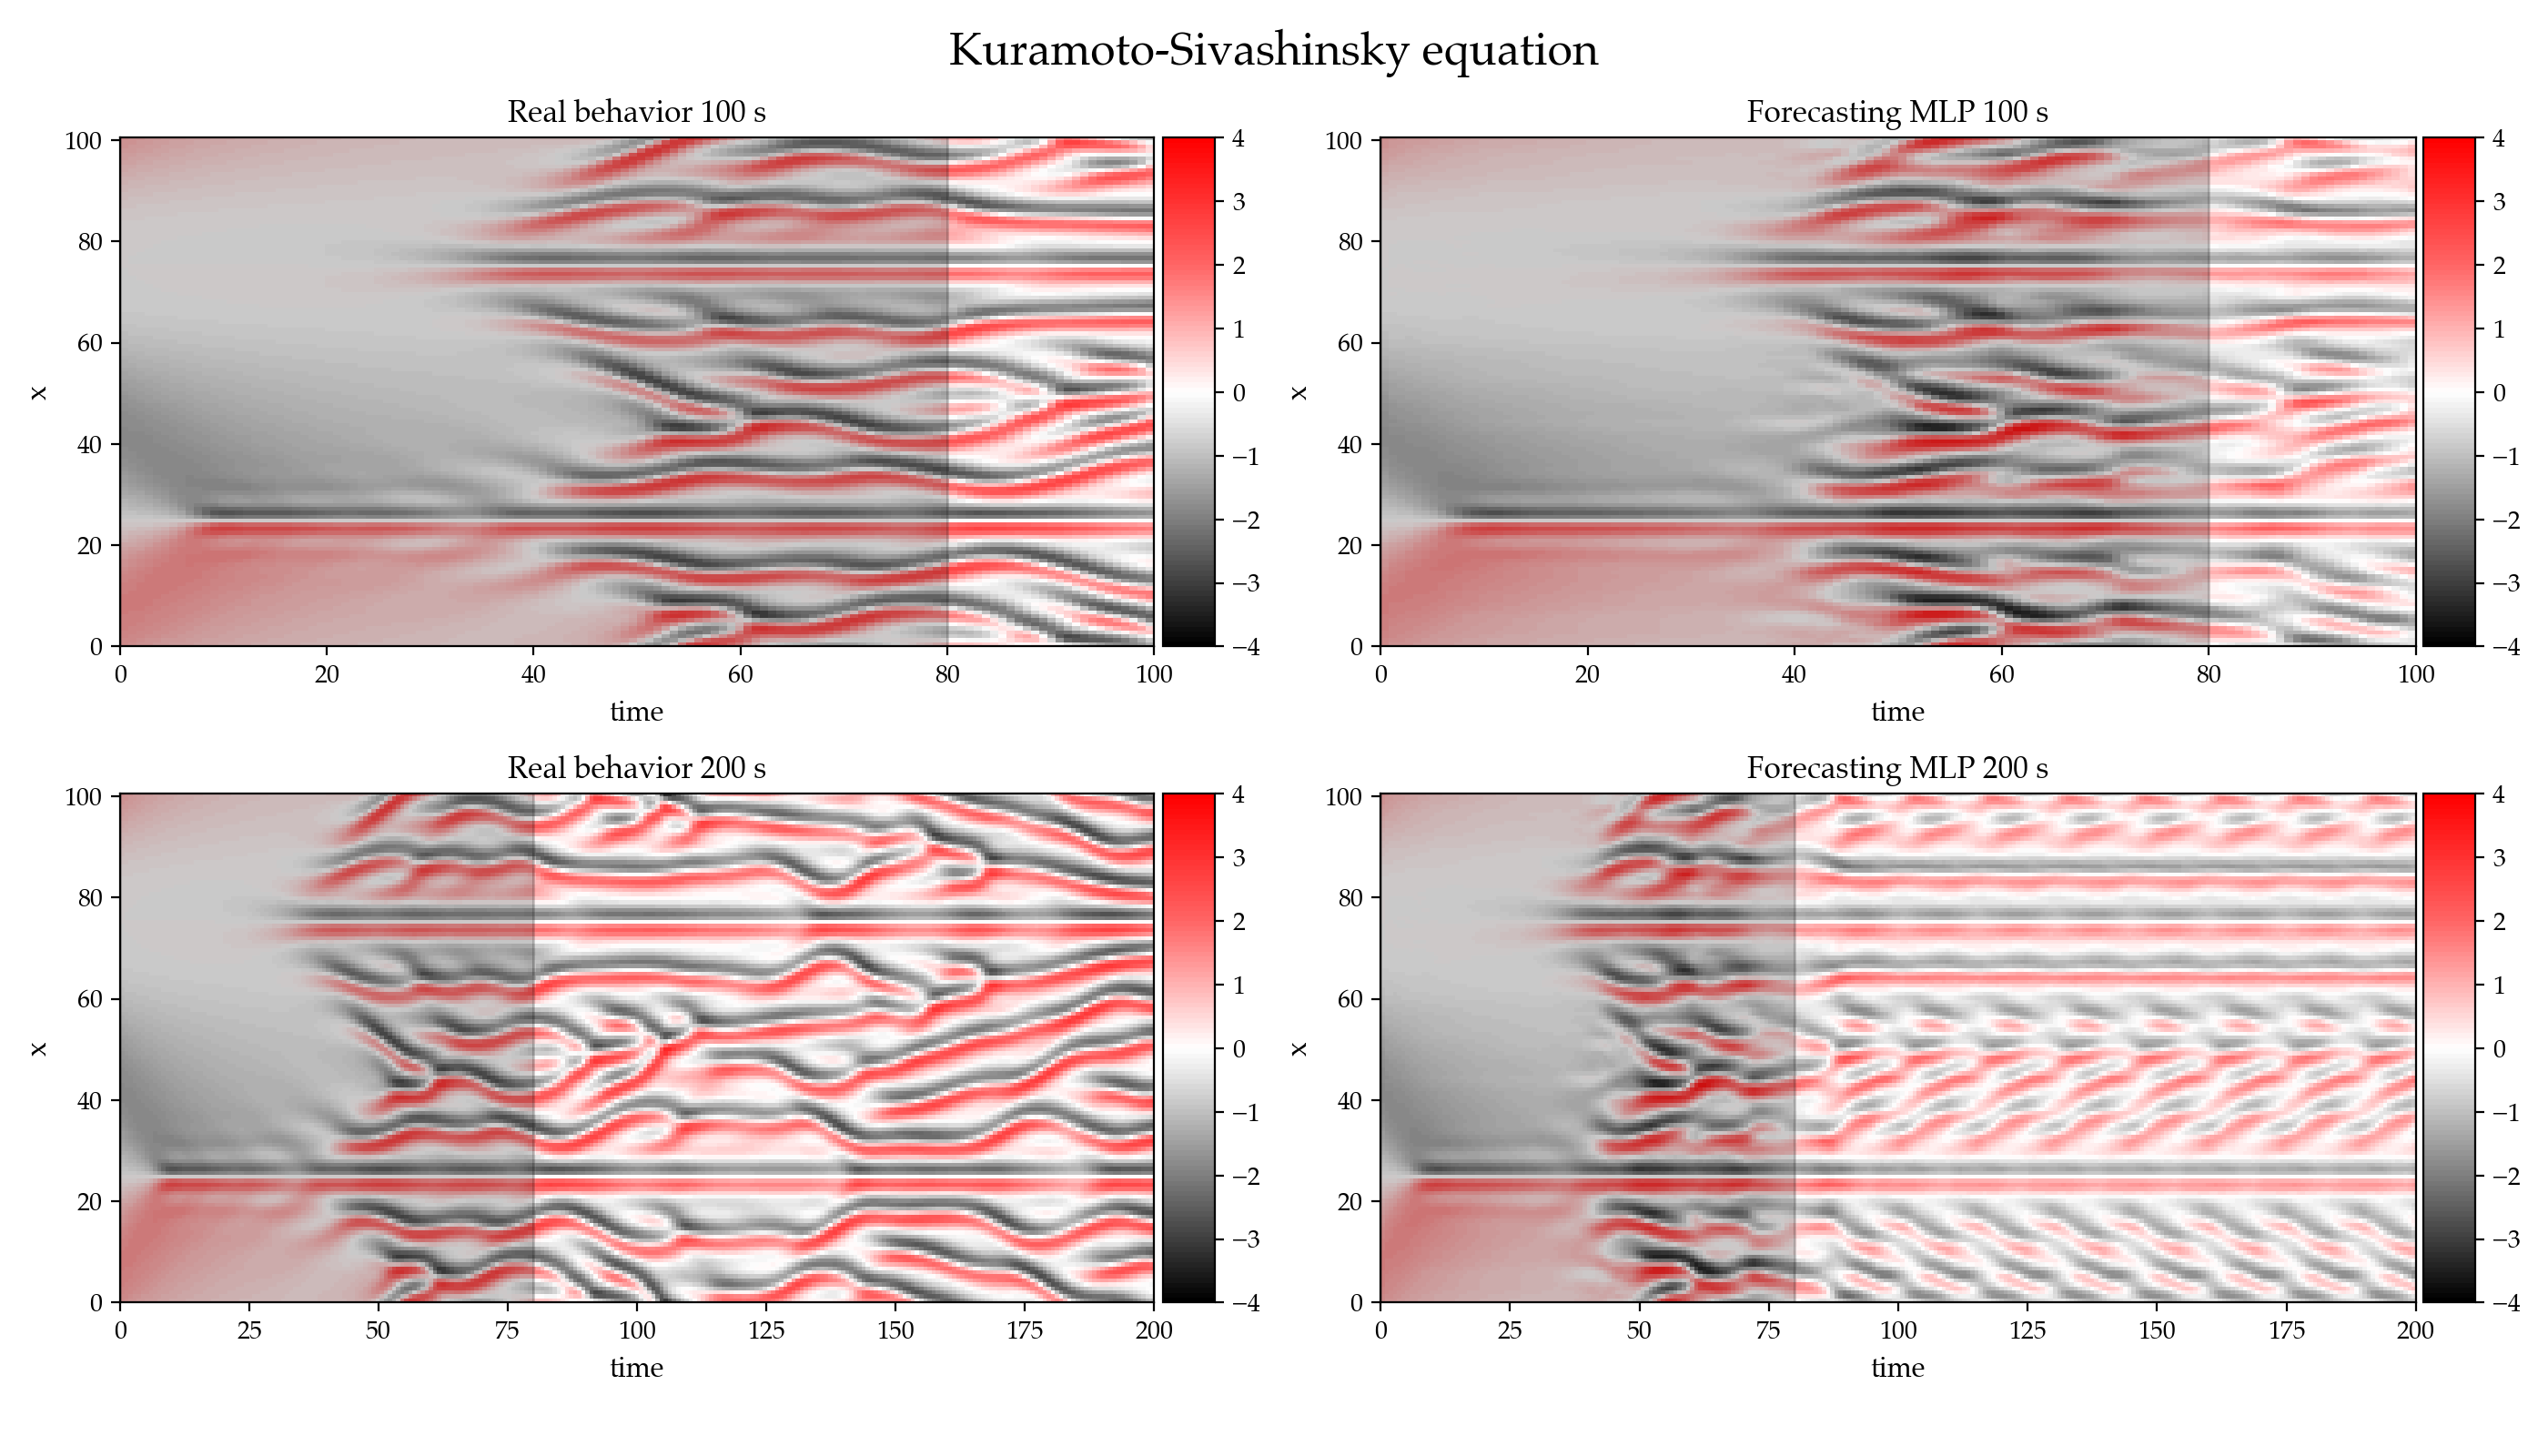

In [0]:
fig = plt.figure(figsize=(14, 8))
fig.suptitle("Kuramoto-Sivashinsky equation", fontsize=18)

norm = mpl.colors.Normalize(vmin=-4, vmax=4)

gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.2)

ax = plt.subplot(gs[0, 0])
h = ax.imshow(u_f1.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max1, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
ax.fill([0, t_train, t_train, 0], [-100, -100, 200, 200], color='k', alpha=0.2)
ax.set_ylim([0, L*np.pi])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title(r'Real behavior %d s' % t_max1, fontsize = 12)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u_frc1.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max1, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
ax.fill([0, t_train, t_train, 0], [-100, -100, 200, 200], color='k', alpha=0.2)
ax.set_ylim([0, L*np.pi])
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP %d s' % t_max1, fontsize = 12)

ax = plt.subplot(gs[1, 0])
h = ax.imshow(u_f2.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max2, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
ax.fill([0, t_train, t_train, 0], [-100, -100, 200, 200], color='k', alpha=0.2)
ax.set_ylim([0, L*np.pi])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Real behavior %d s' % t_max2, fontsize = 12)

ax = plt.subplot(gs[1, 1])
h = ax.imshow(u_frc2.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max2, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
ax.fill([0, t_train, t_train, 0], [-100, -100, 200, 200], color='k', alpha=0.2)
ax.set_ylim([0, L*np.pi])
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP %d s' % t_max2, fontsize = 12)

gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/fore.png', format='png', dpi=1200)

In [0]:
L = 34
t_max = 100
x_f, u_f, t_f = KS(L, n_x, t_max)
n_t = len(t_f)

# Free time marching
u_frc = np.empty((n_t, n_x))
u_frc[0, :] = u_f[0, :]
for i in range(n_t-1):
    with torch.no_grad():
        u_frc[i+1, :] = model2(torch.from_numpy(u_frc[i, :]).squeeze(0).float())

<IPython.core.display.Javascript object>


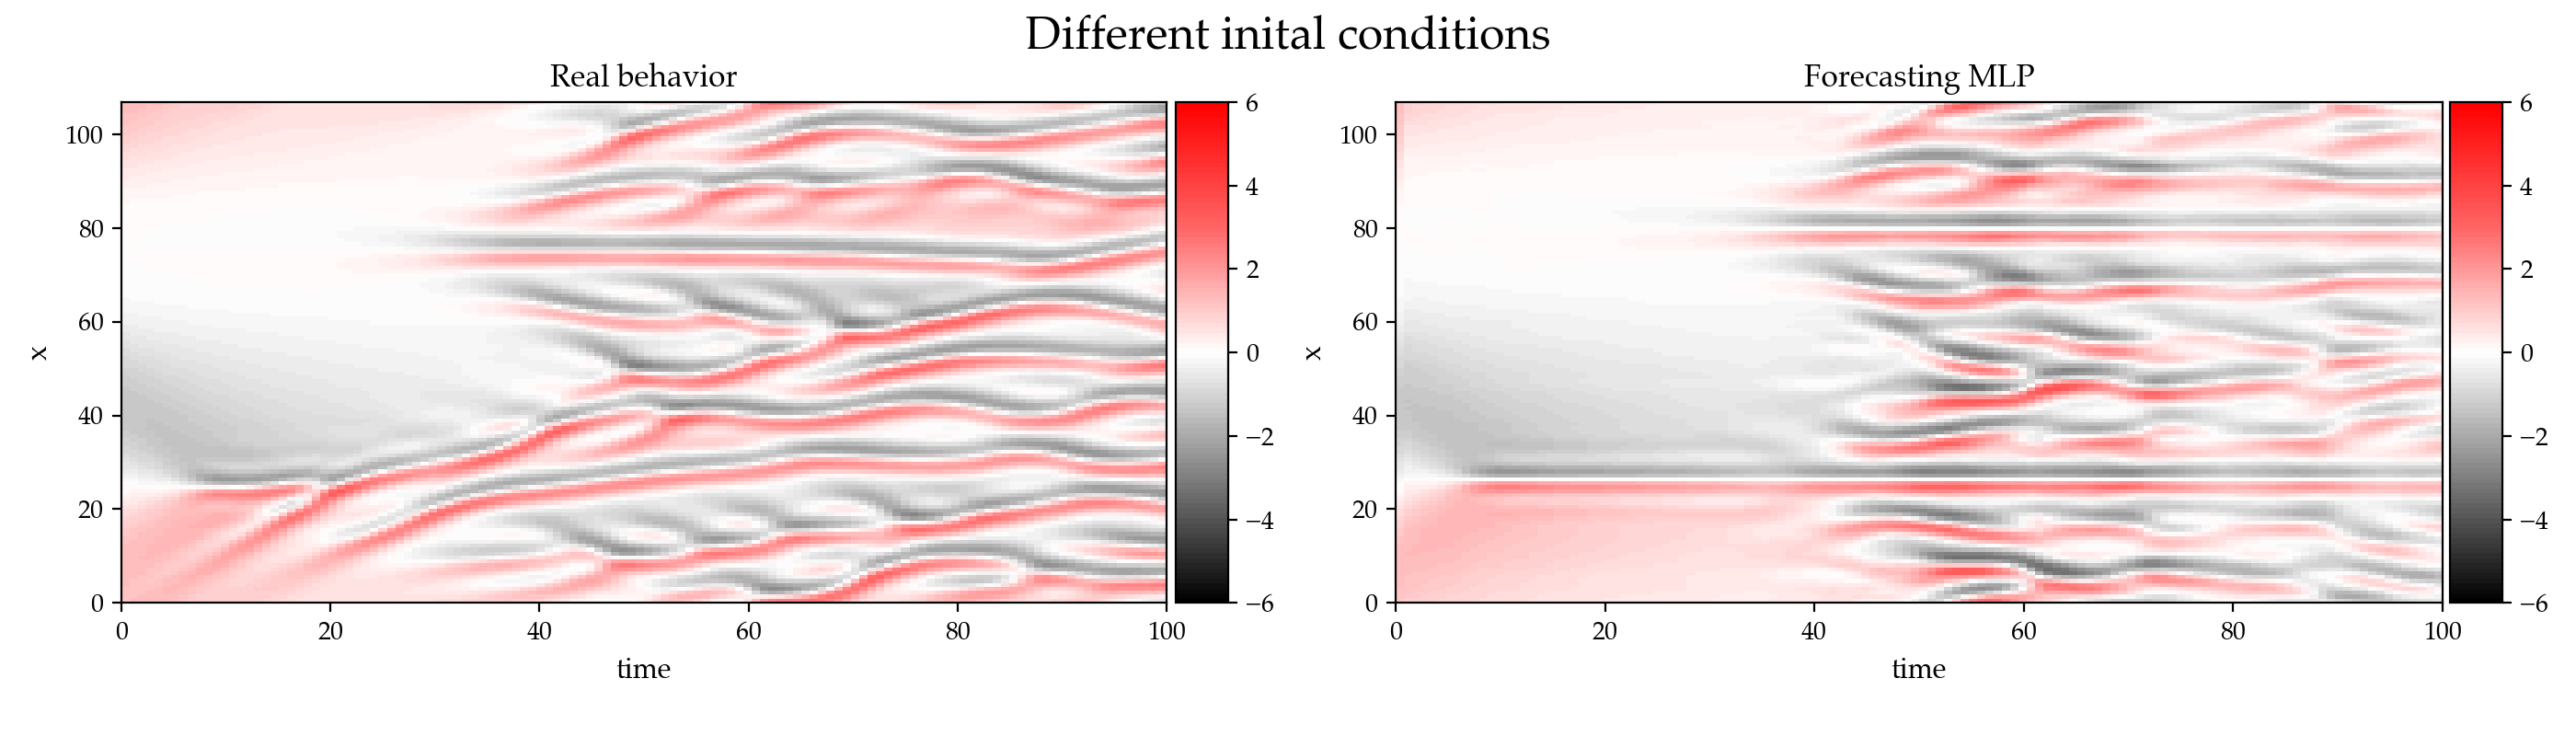

In [0]:
fig = plt.figure(figsize=(14, 4))
fig.suptitle("Different inital conditions", fontsize=18)

norm = mpl.colors.Normalize(vmin=-6, vmax=6)

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.imshow(u_f.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Real behavior', fontsize = 12)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u_frc.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max, 0, L*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP', fontsize = 12)

gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

#fig.savefig('figures/fore_diff_ic.pdf', format='pdf', dpi=1200)

## Point 2: Compare your evolution trajectories for your NN against using the ODE time-stepper provided with different initial conditions



<IPython.core.display.Javascript object>


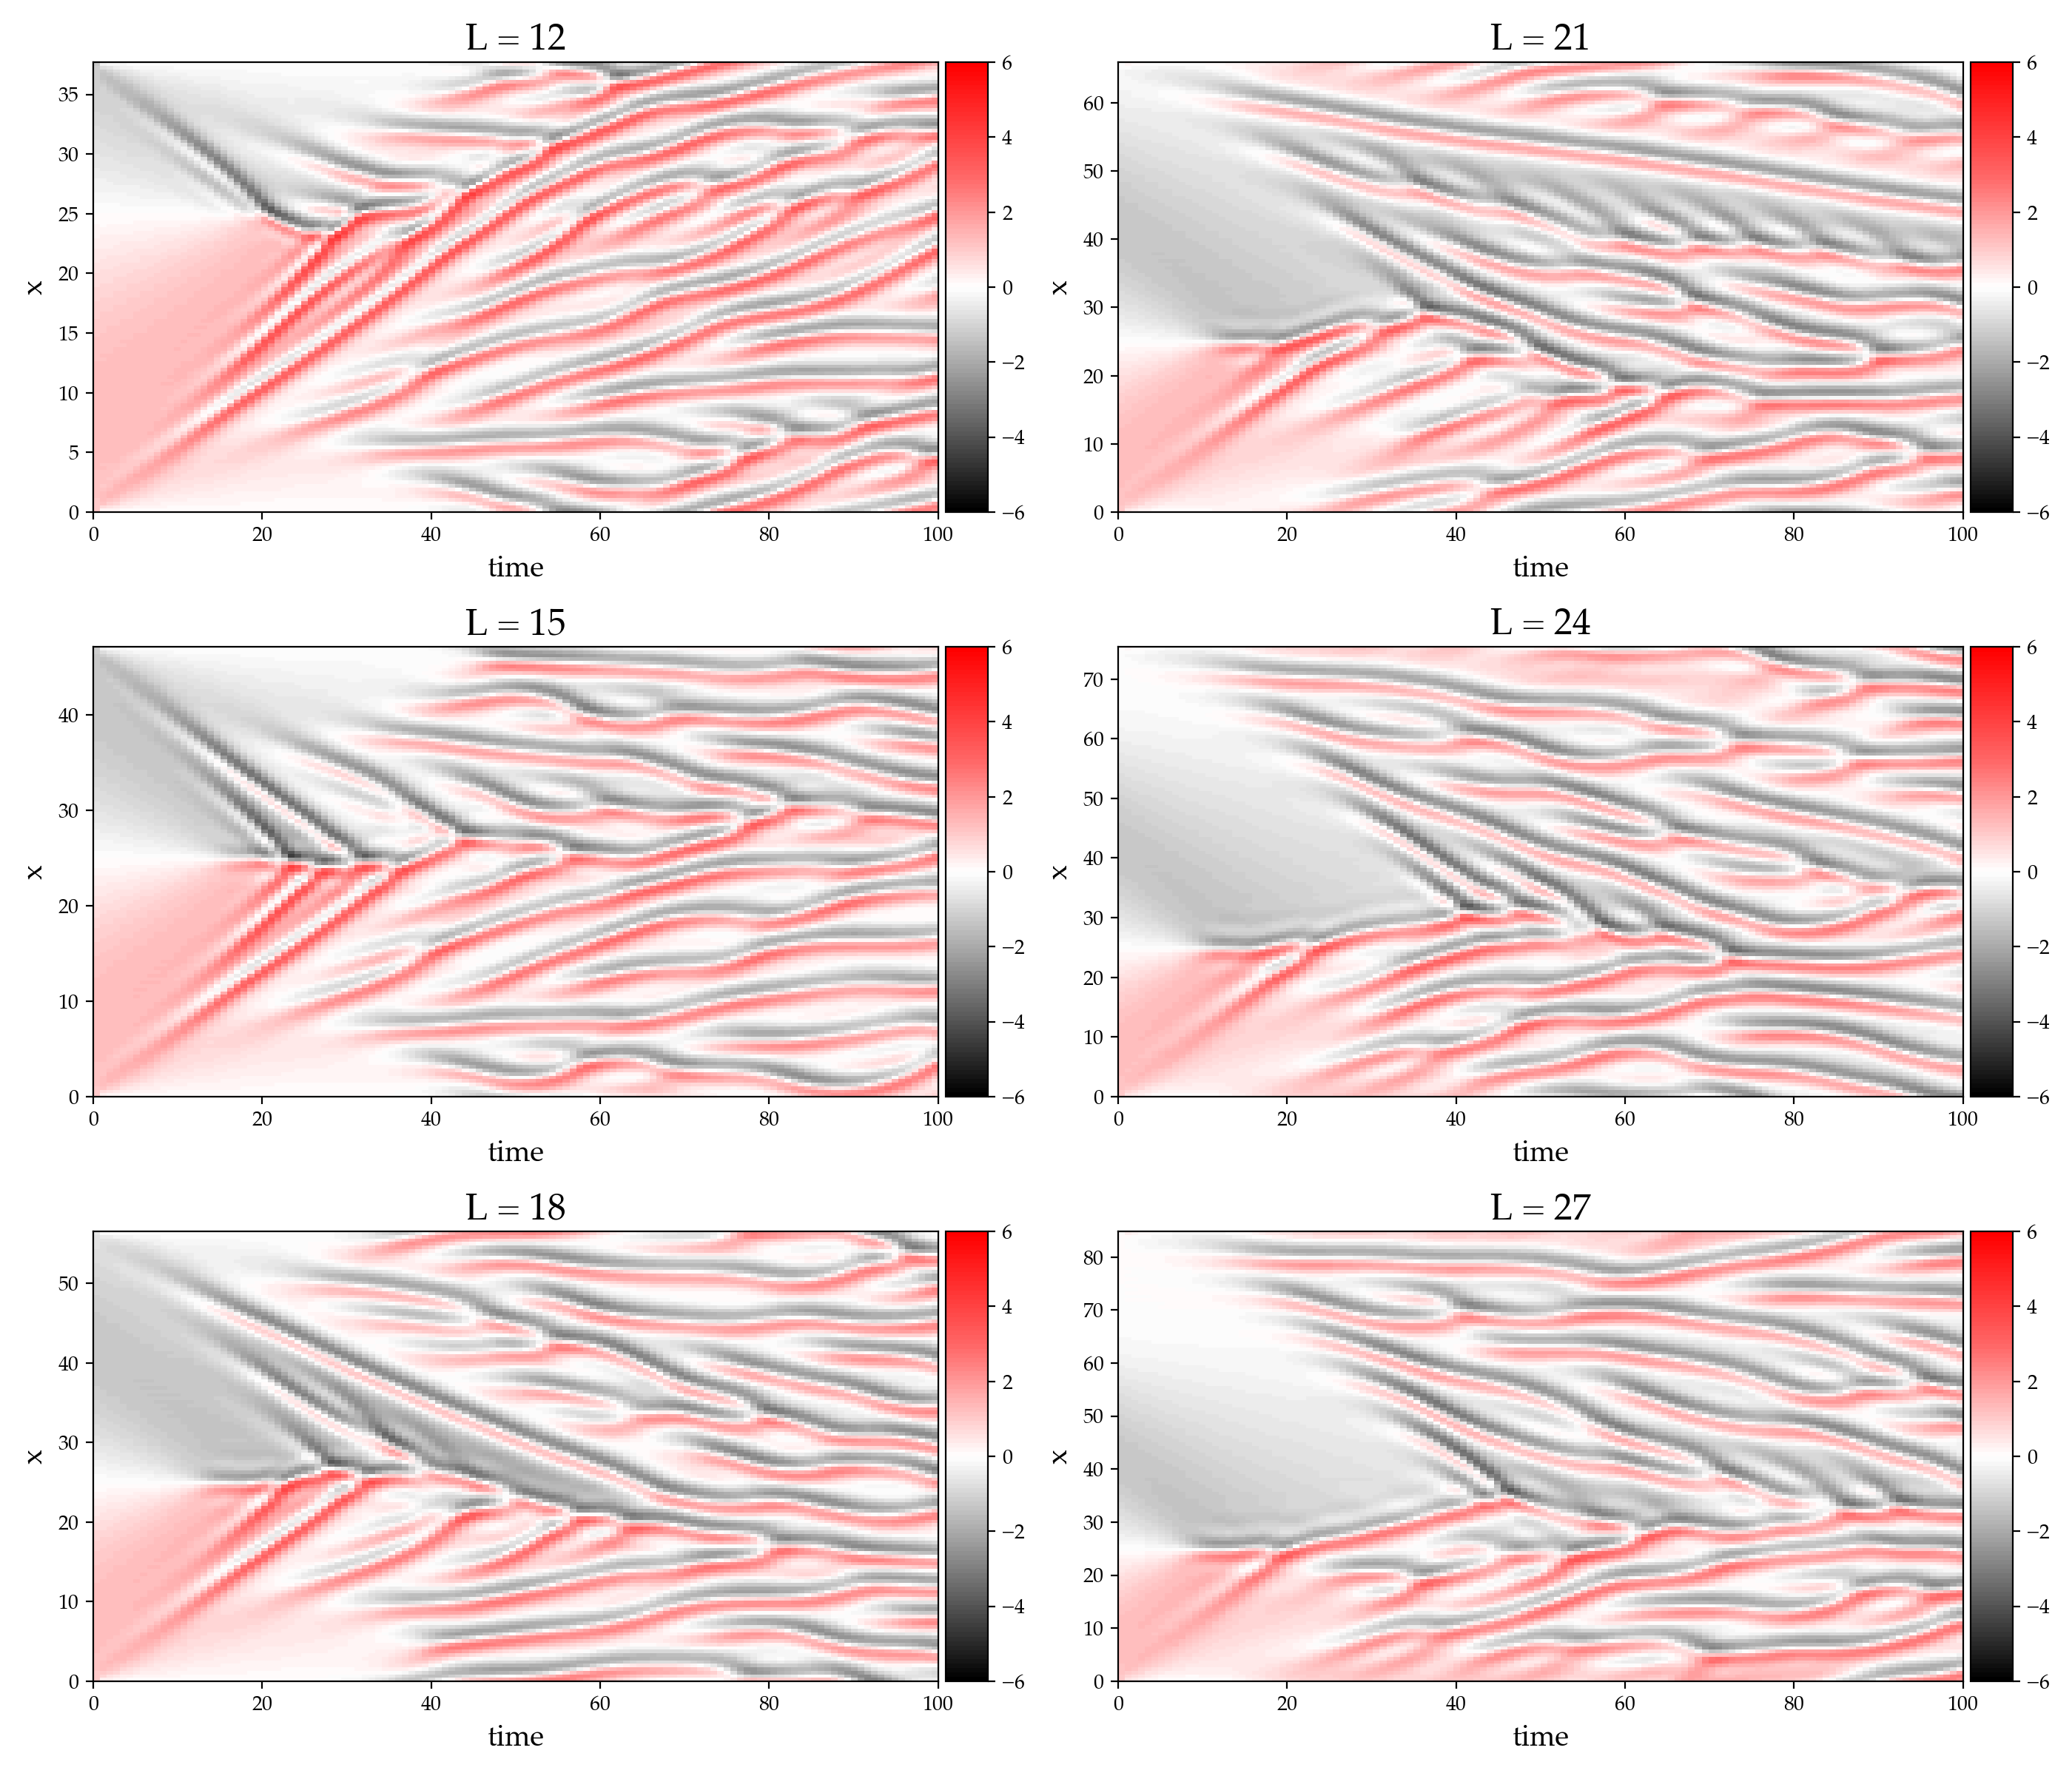

In [122]:
L = [12, 15, 18, 21, 24, 27]
t_max = 100

norm = mpl.colors.Normalize(vmin=-6, vmax=6)

fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(int(len(L) / 2), 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.5)
col = 0
for i in range(len(L)):
    x, u, t = KS(L[i], n_x, t_max)
    if i == int(len(L) / 2):
        col += 1
    ax = plt.subplot(gs[i%int(len(L) / 2), col])
    h = ax.imshow(u.T, interpolation='nearest', cmap=cm, norm=norm,
                extent=[0, t_max, 0, L[i]*np.pi],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('time', fontsize = 14)
    ax.set_ylabel('x', fontsize = 14)
    ax.set_title('L = %d' % L[i], fontsize = 18)
    
gs.tight_layout(fig)

In [0]:
X_train = None
Y_train = None
t_max = 100
for i in range(len(L)):

    x_f, u_f, t_f = KS(L[i], n_x, t_max)

    _X_f = u_f[:-1, :]
    y_f = u_f[1:, :]
    
    ic = np.ones_like(_X_f[None,:, 0]) * L[i]
    
    X_f = np.hstack((_X_f, ic.T))
    
    X_train = X_f if X_train is None else np.vstack((X_train, X_f)) 
    Y_train = y_f if Y_train is None else np.vstack((Y_train, y_f)) 

In [0]:
batch = 32

train_dataset = Data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())

train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True)

In [121]:
D_in, H, D_out = n_x+1, int(2*n_x), n_x

epochs = 5000

model_fore = MLPNN(D_in, H, D_out)

if(os.path.isfile('net_weights/weights_NN_2a5')):
    model_fore.load_state_dict(torch.load('net_weights/weights_NN_2a5'))
    print(model_fore.eval())
else:
    criterion = torch.nn.MSELoss(reduction='sum') 
    optimizer = torch.optim.Adam(model_fore.parameters(), lr=1e-4)
    train_loss = []
    for epoch in range(epochs):
        for step, (batch_x, batch_y) in enumerate(train_loader):
            y_pred = model_fore(batch_x)
            loss = criterion(y_pred, batch_y)
            train_loss.append(loss.item())
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            print("Iteration: ", epoch, " Loss: ", loss.item())
    torch.save(model_fore.state_dict(), 'weights_NN_2a5')

MLPNN(
  (linear1): Linear(in_features=129, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=128, bias=True)
)


In [137]:
L1 = 13
t_max1 = 100
x_f1, u_f1, t_f1 = KS(L1, n_x, t_max1)
n_t1 = len(t_f1)

# Free time marching
u_frc1 = np.empty((n_t1, n_x+1))
u_frc1[0, :-1] = u_f1[0, :]
u_frc1[:, -1] = L1
for i in range(n_t1-1):
    with torch.no_grad():
        u_frc1[i+1, :-1] = model_fore(torch.from_numpy(u_frc1[i, :]).squeeze(0).float())
        
L2 = 26       
t_max2 = 100
x_f2, u_f2, t_f2 = KS(L2, n_x, t_max2)
n_t2 = len(t_f2)

# Free time marching
u_frc2 = np.empty((n_t2, n_x+1))
u_frc2[0, :-1] = u_f2[0, :]
u_frc2[:, -1] = L2
for i in range(n_t-1):
    with torch.no_grad():
        u_frc2[i+1, :-1] = model_fore(torch.from_numpy(u_frc2[i, :]).squeeze(0).float())

<IPython.core.display.Javascript object>


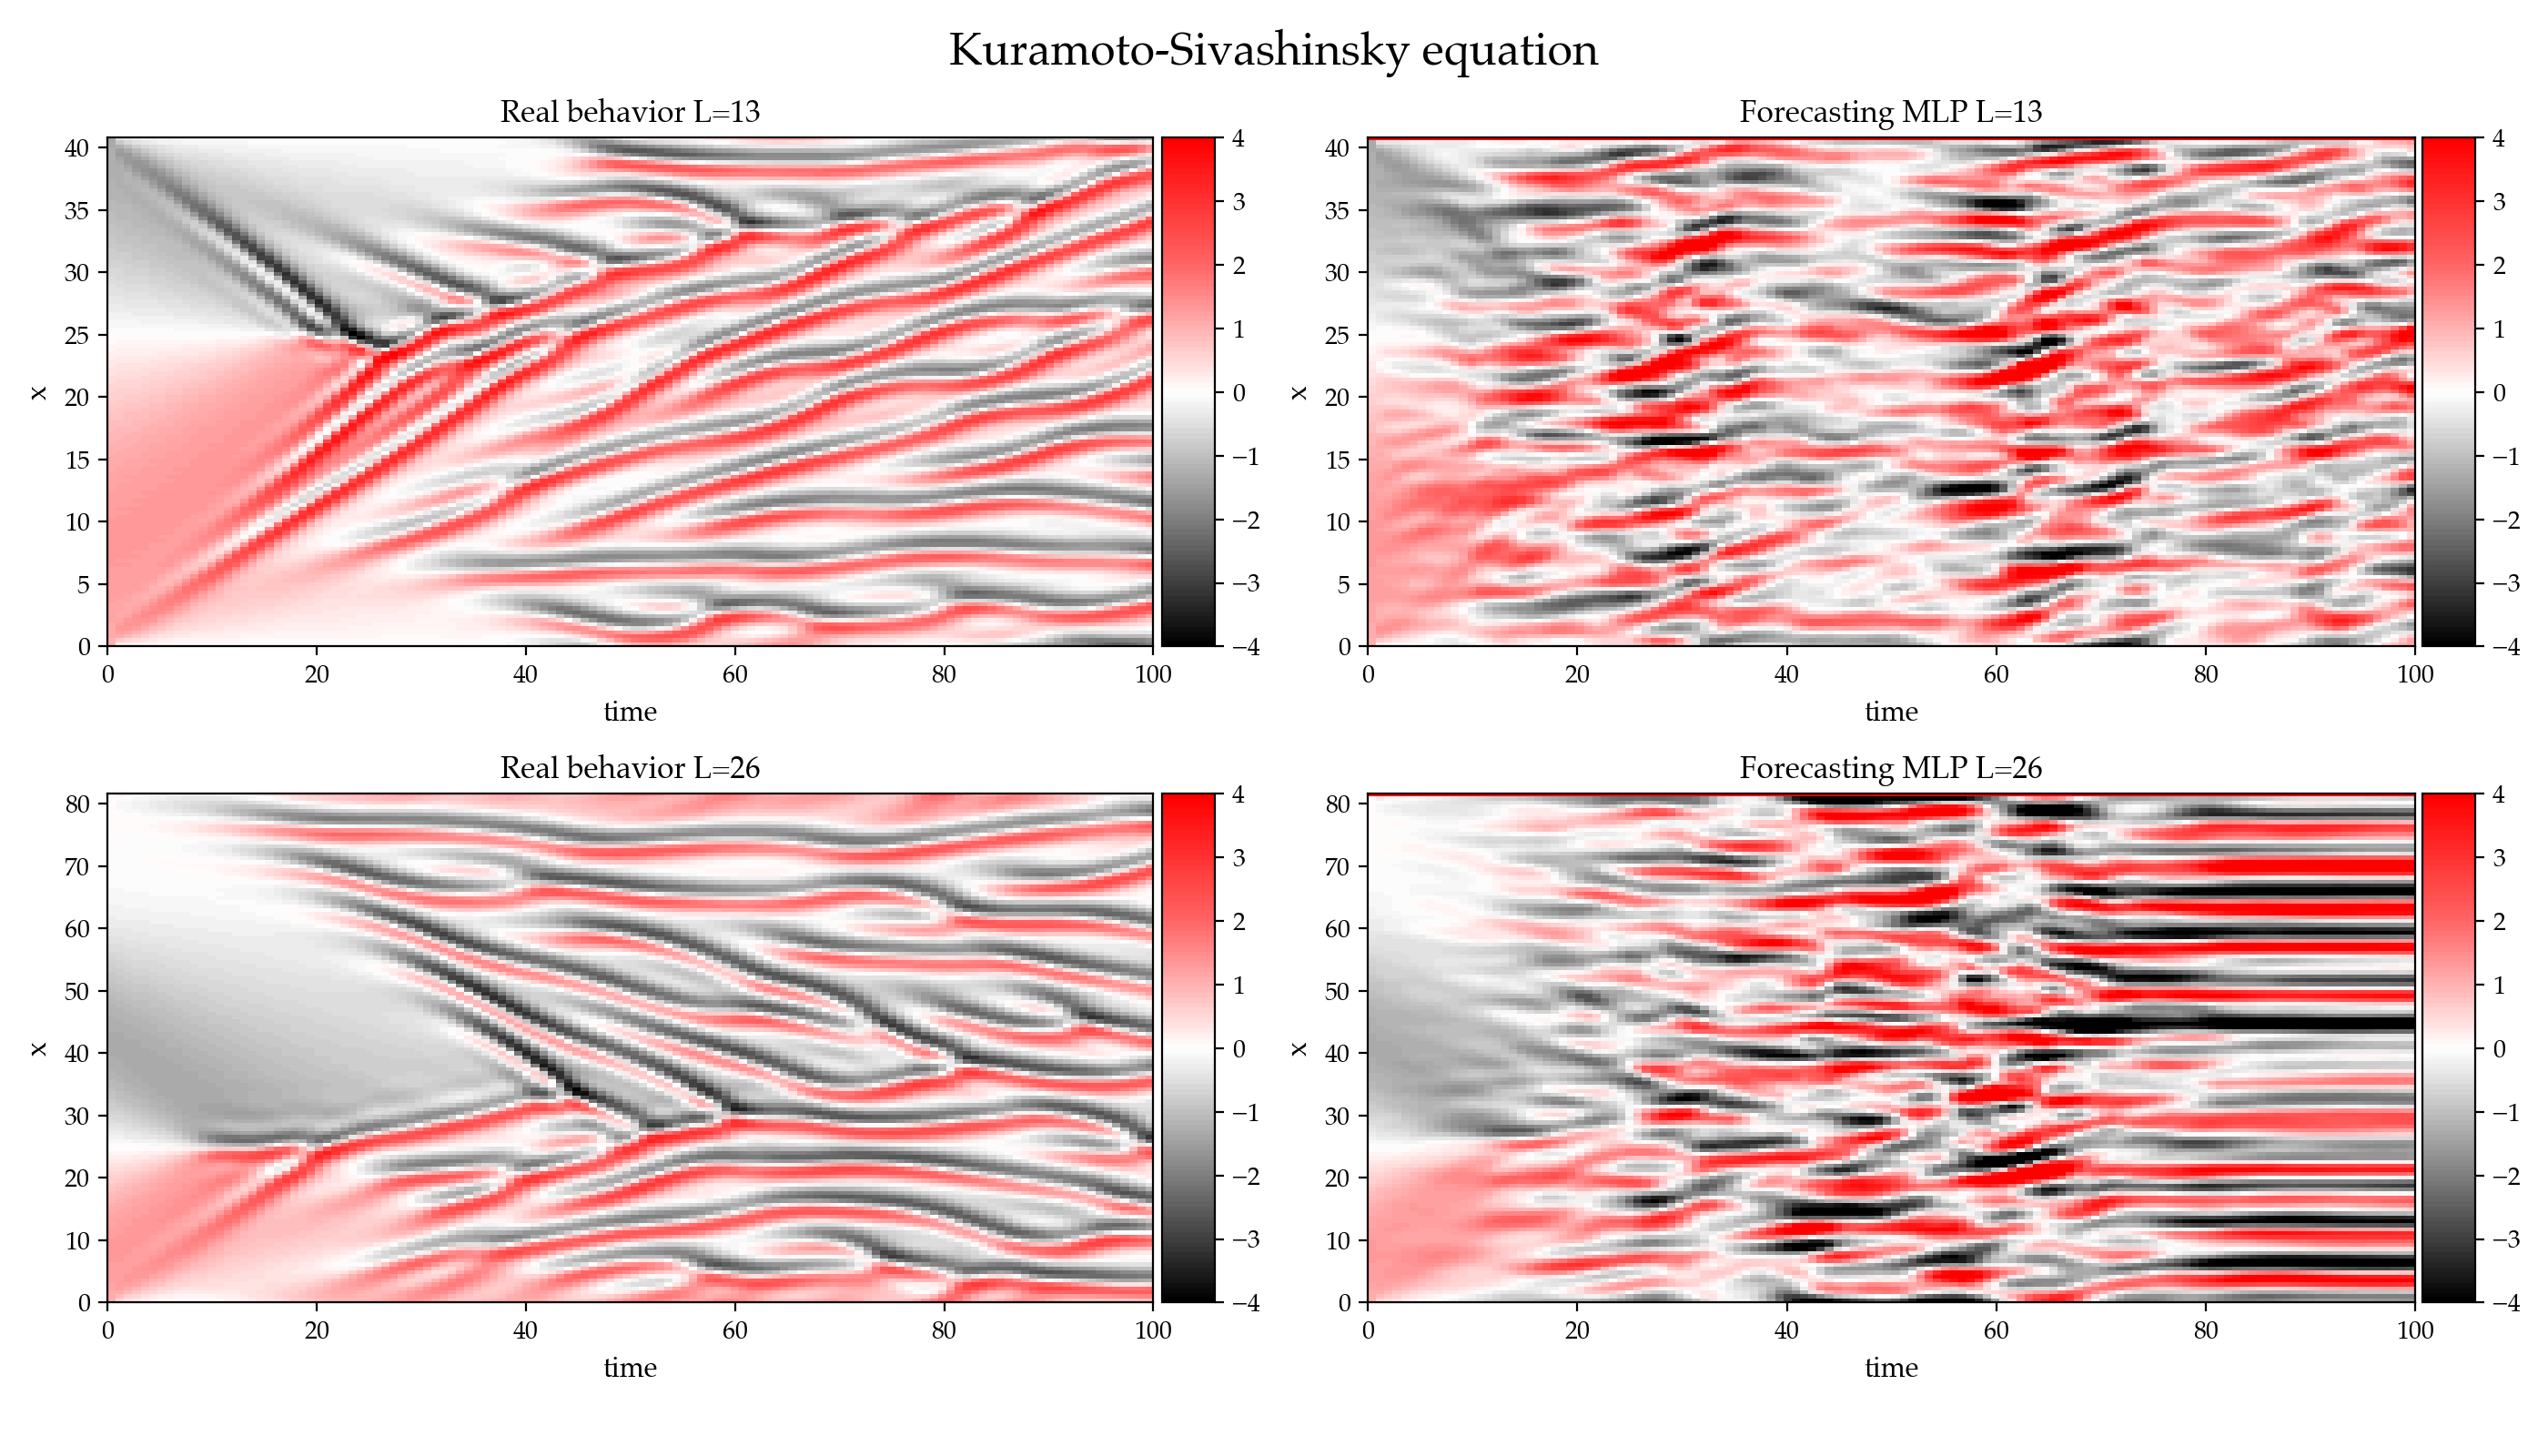

In [139]:
fig = plt.figure(figsize=(14, 8))
fig.suptitle("Kuramoto-Sivashinsky equation", fontsize=18)

norm = mpl.colors.Normalize(vmin=-4, vmax=4)

gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.2)

ax = plt.subplot(gs[0, 0])
h = ax.imshow(u_f1.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max1, 0, L1*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title(r'Real behavior L=%d' % L1, fontsize = 12)

ax = plt.subplot(gs[0, 1])
h = ax.imshow(u_frc1.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max1, 0, L1*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP L=%d' % L1, fontsize = 12)

ax = plt.subplot(gs[1, 0])
h = ax.imshow(u_f2.T, interpolation='nearest', cmap=cm, norm=norm,
              extent=[0, t_max1, 0, L2*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Real behavior L=%d' % L2, fontsize = 12)

ax = plt.subplot(gs[1, 1])
h = ax.imshow(u_frc2.T, interpolation='nearest', cmap=cm, norm=norm, 
              extent=[0, t_max1, 0, L2*np.pi],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.04)
fig.colorbar(h, cax=cax)
ax.set_xlabel('time', fontsize = 11)
ax.set_ylabel('x', fontsize = 11)
ax.set_title('Forecasting MLP L=%d' % L2, fontsize = 12)

gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/diff_ic.png', format='png', dpi=1200)